Hello, I am JYC. This notebook implements some sub-tasks in experimental topic 4. I will explain the logic behind each concept to assist students who are not proficient in coding to quickly grasp the key points and complete the experiment.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import numpy as np
import copy
from tqdm import trange

### Direct Interaction Multi-Agent Self-Organization Mechanisms

In this section, I will present two direct interaction multi-agent self-organization mechanisms: Degree-Based Connection and Random Global Connection.

1. **Degree-Based Connection**: An agent selects the neighbor with the highest degree that is not already connected to itself and establishes a connection with this agent. Simultaneously, it selects the neighbor with the smallest degree among its connected neighbors and disconnects from this agent.

2. **Random Global Connection**: An agent randomly selects any agent in the network that is not already connected to itself and establishes a connection with this agent. Simultaneously, it randomly selects an agent among its connected neighbors and disconnects from this agent.

For simplicity, we use nodes in a graph to represent agents. Initially, we create a random graph, displaying newly created edges in green and other edges in gray.

In [2]:
def degree_based_update(G):
    new_edges = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        non_neighbors = list(set(G.nodes()) - set(neighbors) - {node})
        if non_neighbors:
            max_degree_neighbor = max(non_neighbors, key=lambda x: G.degree(x))
            new_edges.append((node, max_degree_neighbor))
    return new_edges


def random_global_update(G):
    new_edges = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        non_neighbors = list(set(G.nodes()) - set(neighbors) - {node})
        if non_neighbors:
            random_neighbor = random.choice(non_neighbors)
            new_edges.append((node, random_neighbor))
    return new_edges


def update_and_visualize(G1, G2, pos, interval, iterations):
    previous_edges1 = set()
    previous_edges2 = set()

    for _ in range(iterations):
        clear_output(wait=True)
        print(f"Updating and visualizing graphs... Iteration {_+1}/{iterations}")

        new_edges1 = degree_based_update(G1)
        G1.remove_edges_from(list(G1.edges()))
        G1.add_edges_from(new_edges1)

        new_edges2 = random_global_update(G2)
        G2.remove_edges_from(list(G2.edges()))
        G2.add_edges_from(new_edges2)

        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        nx.draw(
            G1,
            pos,
            node_color="lightblue",
            edge_color="gray",
            style="solid",
            node_shape="o",
        )
        nx.draw_networkx_edges(
            G1, pos, edgelist=list(previous_edges1), edge_color="green", style="solid"
        )
        plt.title("Degree-Based Connection")

        plt.subplot(122)
        nx.draw(
            G2,
            pos,
            node_color="lightblue",
            edge_color="gray",
            style="solid",
            node_shape="o",
        )
        nx.draw_networkx_edges(
            G2, pos, edgelist=list(previous_edges2), edge_color="green", style="solid"
        )
        plt.title("Random Global Connection")

        plt.pause(interval)
        plt.clf()
        previous_edges1 = set(new_edges1)
        previous_edges2 = set(new_edges2)

Updating and visualizing graphs... Iteration 10/10


<Figure size 640x480 with 0 Axes>

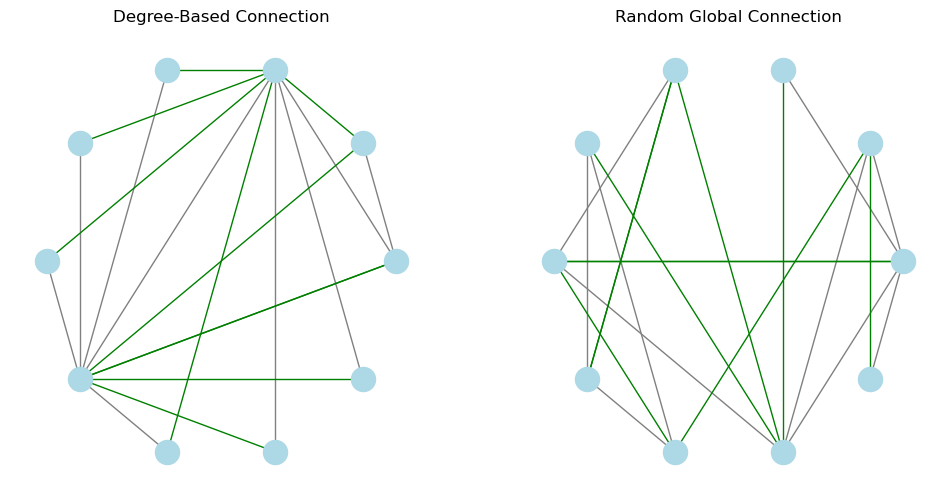

<Figure size 640x480 with 0 Axes>

In [3]:
n = 10 
G1 =  nx.gnp_random_graph(n, 0.2)
G2 = copy.deepcopy(G1)
update_and_visualize(G1, G2, nx.circular_layout(G1), interval=1, iterations=10) 

### Indirect Interaction Self-Organization Mechanism

In this section, we implement a self-organization mechanism based on intermediary nodes, where agents establish connections through intermediaries. This mechanism is divided into two types of agents: executor agents and intermediary agents.

- **Executor Agents**: These agents are responsible for executing tasks, recording resource utilization, and canceling unnecessary connections.
- **Intermediary Agents**: These agents receive connection adjustment requests from executor agents and recommend suitable connection candidates for them. Additionally, there is a state-switching mechanism among agents: an executor agent with very few tasks can switch to an intermediary agent role, taking over the connection adjustment work for an overloaded agent with a heavy task load.

We also use a graph to simulate the entire process. At the beginning, we initialize a random graph and assign a load to each node sampled from $ N(\mu, \sigma^2) $. The nodes with the lowest 20% of the load are designated as intermediary nodes.Then, all working nodes randomly choose an intermediary node to connect with.

Next, we proceed with the work iterations. Overall, this process aims to reduce the overall load variance across nodes. Each working node randomly reduces its load by a certain amount and distributes this load to all its neighboring nodes. The task of intermediary nodes is to connect the working nodes linked to them to the working node with the lowest load. If this working node has too many connections (more than three), it will disconnect from the node with the highest load among its connections.

This iteration is repeated, and at the end of each iteration, roles are reassigned.

### Summary of Steps:

1. **Initialization**:
   - Create a random graph.
   - Assign a load to each node sampled from \( N(\mu, \sigma^2) \).
   - Designate the nodes with the lowest 20% of the load as intermediary nodes.
   - All working nodes randomly connect to one intermediary node.

2. **Iteration Process**:
   - Each working node reduces its load by a random amount and distributes this load to all its neighboring nodes.
   - Intermediary nodes connect the working nodes linked to them to the working node with the lowest load.
   - If a working node has more than three connections, it disconnects from the node with the highest load among its connections.

3. **Role Reassignment**:
   - At the end of each iteration, roles are reassigned based on the current load, with the nodes having the lowest 20% load becoming intermediary nodes. 

This iterative process continues until the overall load variance across the nodes is minimized.

In [4]:
def initialize_graph(n, mu, sigma):
    G = nx.Graph()
    # init graph
    loads = np.random.normal(mu, sigma, n)
    for i in range(n):
        G.add_node(i, load=loads[i], type="worker")
    set_node_role(G)

    # connect workers and intermediaries
    workers = [n for n, attr in G.nodes(data=True) if attr["type"] == "worker"]
    intermediaries = [
        n for n, attr in G.nodes(data=True) if attr["type"] == "intermediary"
    ]
    for worker in workers:
        G.add_edge(worker, random.choice(intermediaries))

    return G


def set_node_role(G):
    for _, attr in G.nodes(data=True):
        attr["type"] = "worker"
    low_load_nodes = sorted(G.nodes(data=True), key=lambda x: x[1]["load"])[
        : int(0.2 * len(G.nodes()))
    ]
    for node, data in low_load_nodes:
        data["type"] = "intermediary"


def work_and_adjust(G):
    new_edges = []
    for n, attr in G.nodes(data=True):
        if attr["type"] == "worker":
            # worker flow
            load_reduction = random.uniform(0, attr["load"] * 0.1)
            attr["load"] -= load_reduction
            neighbors = list(G.neighbors(n))
            if neighbors:
                load_share = load_reduction / len(neighbors)
                for neighbor in neighbors:
                    G.nodes[neighbor]["load"] += load_share
        else:
            # intermediary flow
            neighbors = [
                nei for nei in G.neighbors(n) if G.nodes[nei]["type"] == "worker"
            ]
            for nei in neighbors:
                other_workers = [
                    w
                    for w in G.nodes()
                    if w != nei
                    and G.nodes[w]["type"] == "worker"
                    and not G.has_edge(w, nei)
                ]
                if other_workers:
                    new_worker = min(
                        other_workers, key=lambda x: (G.nodes[x]["load"], G.degree(x))
                    )
                    new_edges.append((nei, new_worker))
                    if G.degree(nei) > 3:
                        G.remove_edge(nei, max(
                            G.neighbors(nei), key=lambda x: G.nodes[x]["load"]
                        ))

    for edge in new_edges:
        G.add_edge(*edge)

    return new_edges


def update_and_visualize(G, pos, interval, iterations):
    for _ in range(iterations):
        clear_output(wait=True)
        print(f"Updating and visualizing graphs... Iteration {_+1}/{iterations}")
        new_edges = work_and_adjust(G)
        set_node_role(G)
        nx.draw(
            G,
            pos,
            node_color=[
                "lightgrey" if attr["type"] != "intermediary" else "lightblue"
                for _, attr in G.nodes(data=True)
            ],
            node_size=[attr["load"] * 50 for _, attr in G.nodes(data=True)],
            edge_color="gray",
        )
        for n, attr in G.nodes(data=True):
            plt.text(
                pos[n][0],
                pos[n][1],
                f"{attr['load']:.2f}",
                fontsize=8,
                verticalalignment="bottom",
                horizontalalignment="center",
            )

        if new_edges:
            nx.draw_networkx_edges(
                G, pos, edgelist=new_edges, edge_color="green", style="dashed"
            )
        plt.show()
        plt.pause(interval)
        plt.clf()


Updating and visualizing graphs... Iteration 10/10


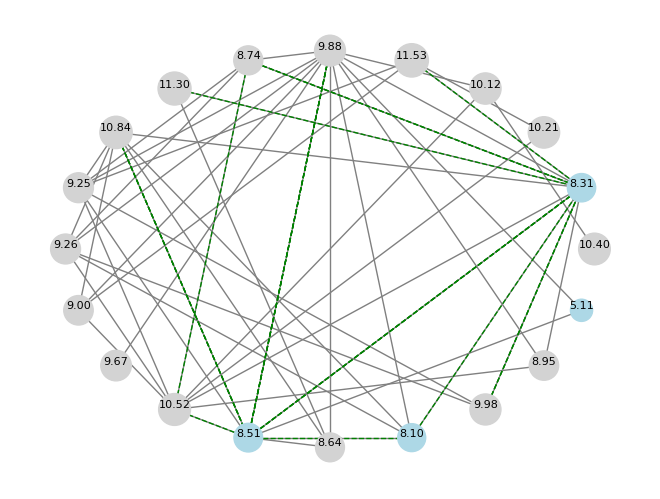

(9.415497326470367, 1.3741807009448246)

<Figure size 640x480 with 0 Axes>

In [5]:
n = 20
mu = 10
sigma = 5

G = initialize_graph(n, mu, sigma)
pos = nx.circular_layout(G)
update_and_visualize(G, pos, interval=2, iterations=10)

loads = [attr["load"] for _, attr in G.nodes(data=True)]

mean_load = np.mean(loads)
std_dev_load = np.std(loads)

mean_load, std_dev_load

### Reinforcement and Greedy-Based Resource Self-Organization Mechanism

In this section, we implement a resource self-organization mechanism based on reinforcement and greedy strategies. The reinforcement strategy involves initially allocating a certain amount of resources and then adjusting these resources based on the agent's performance (e.g., load rate, revenue, task completion). The greedy strategy prioritizes fulfilling the resource requests of the best-performing agent at the current moment.

We simulate this environment using the k-armed bandit problem. A k-armed bandit has k arms, each of which gives a reward when pulled. In each round, the player has a limited number of opportunities to pull any arm, aiming to maximize the average reward over a certain number of rounds. In this scenario, each arm can be considered as an agent, and the reward represents the agent's performance score. The player allocates limited resources to the agents based on their performance.

In [6]:
class Bandit:
    def __init__(self, k_arm=10):
        self.k = k_arm
        self.q_true_means = np.random.uniform(1, 9, self.k)
        self.q_true_stds = np.random.uniform(0.5, 2, self.k)

    def reset(self):
        self.q_true = [np.random.normal(mean, std) for mean, std in zip(self.q_true_means, self.q_true_stds)]
        self.q_true = np.clip(self.q_true, 0, 10)

    def pull(self, arm):
        reward = np.random.normal(self.q_true_means[arm], self.q_true_stds[arm])
        return np.clip(reward, 0, 10)

class Player:
    def __init__(self, bandit, epsilon=0., initial=0., step_size=0.1, sample_averages=False):
        self.bandit = bandit
        self.epsilon = epsilon
        self.initial = initial
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.bandit.k)
        self.time = 0

    def reset(self):
        self.q_estimation = np.zeros(self.bandit.k) + self.initial
        self.action_count = np.zeros(self.bandit.k)
        self.time = 0

    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        reward = self.bandit.pull(action)
        self.time += 1
        self.action_count[action] += 1
        if self.sample_averages:
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        else:
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

def simulate(runs, time, players):
    rewards = np.zeros((len(players), runs, time))
    for i, player in enumerate(players):
        for r in trange(runs):
            player.reset()
            player.bandit.reset()
            for t in range(time):
                action = player.act()
                reward = player.step(action)
                rewards[i, r, t] = reward
    mean_rewards = rewards.mean(axis=1)
    return mean_rewards

def figure_epsilon_greedy(runs=200, time=100):
    epsilons = [0, 0.1, 0.01]
    bandit = Bandit()
    players = [Player(bandit, epsilon=eps, sample_averages=True) for eps in epsilons]
    rewards = simulate(runs, time, players)

    plt.figure(figsize=(10, 6))

    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

    plt.savefig('./figure_epsilon_greedy.png')
    plt.close()


Each arm of the bandit holds a distribution $N(\mu, \sigma^2)$, where the mean and variance are sampled from a uniform distribution. Each time an arm is pulled, a value is sampled from its distribution as a reward. Let's use a violin plot to show the distributions of these arms.

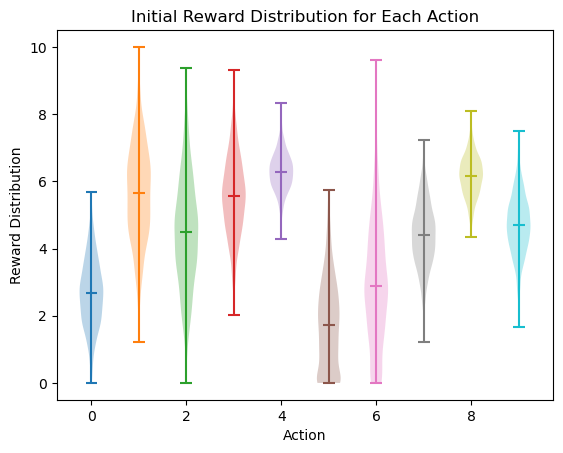

In [7]:
bandit = Bandit()

for i in range(bandit.k):
    data = np.clip(np.random.normal(bandit.q_true_means[i], bandit.q_true_stds[i], 1000), 0, 10)
    plt.violinplot(data, positions=[i], showmeans=False, showmedians=True)
plt.xlabel("Action")
plt.ylabel("Reward Distribution")
plt.title("Initial Reward Distribution for Each Action")
plt.show()

Here we created three players, each operating with an $\varepsilon$-greedy strategy. The values of $\varepsilon$ are 0, 0.05, and 0.1, respectively. Note that when $\varepsilon=0$, it is a purely greedy strategy, as it never explores other arms with lower rewards.

100%|██████████| 200/200 [00:02<00:00, 67.12it/s]


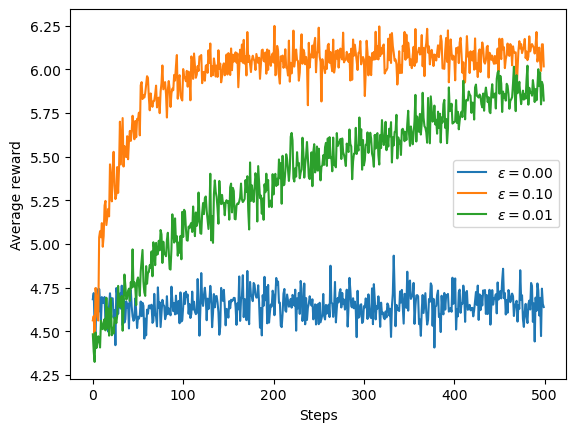

: 

In [8]:
epsilons = [0, 0.1, 0.01]
runs = 200
time = 500

players = [Player(bandit, epsilon=eps, sample_averages=True) for eps in epsilons]
rewards = simulate(runs, time, players)

for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()